In [1]:
%matplotlib inline
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
from Games import *
import Utility
from os import listdir, mkdir
from os.path import join, isdir
from json import load
from glob import glob

In [3]:
FIGURE = 'figure'
if not isdir(FIGURE):
    mkdir(FIGURE)

In [4]:
PALETTE = {
    "Policy": "red", 
    "Q": "blue", 
    "Random": "green", 
    "Greedy": "purple"
}

# Mario Level Segments

In [5]:
def get_all_player_playthroughs(config, reward_str):
    playthroughs = []
    for path in glob(join(config.BASE_DIR, f'player*reward_{reward_str}.json')):
        path_split = path.split('/')[-1].split('_')
        player = path_split[1]
        director = path_split[-3]
        
        with open(path, 'r') as f:
            playthroughs.append((player, director, load(f)))

    return playthroughs

In [6]:
def get_df(playthroughs, order_column):
    data = []
    labels = ['Director', 'Player', 'Percent Complete', 'Player Reward', 'Design Reward','Both Reward']
    players = set()
    
    for player, director, run_data in playthroughs:
        players.add(player)
        for run in run_data:
            run_percent_complete = 0
            run_player_reward = 0
            run_design_reward = 0
            run_total_reward = 0

            for lvl in run:
                run_percent_complete += lvl['percent_complete']
                run_player_reward += lvl['percent_player_reward']
                run_design_reward += lvl['percent_design_reward']
                run_total_reward += lvl['percent_total_reward']
                    
            data.append((
                director, 
                player, 
                run_percent_complete / len(run), 
                run_player_reward / len(run), 
                run_design_reward / len(run), 
                run_total_reward / len(run)))
    
    df = pd.DataFrame(data, columns=labels) \
         .groupby(['Player', 'Director']) \
         .agg(['mean', 'std']) \
         .sort_values(by=['Player', (order_column, 'mean')], ascending=False)
    df = df.applymap("{0:.3f}".format)
    return df

In [7]:
def plot_player_personas_over_time(data_info):
    data = {}
    
    for name, playthrough, _ in data_info:
        data[name] = {}
        
        for player, alg, playthrough_data in playthrough:
            if player not in data[name]:
                data[name][player] = []
            
            for session in playthrough_data:
                total_reward = 0
                for i, lvl in enumerate(session):
                    if name == data_info[0][0]:
                        total_reward += lvl['percent_design_reward']
                    elif name == data_info[1][0]:
                        total_reward += lvl['percent_player_reward']
                    elif name == data_info[2][0]:
                        total_reward += lvl['percent_total_reward']
                    else:
                        raise KeyError(f'Unknown key: {name}.')
                        
                    data[name][player].append((alg, i, total_reward))
                        

    # sort keys so the output is always in the same order
    player_names = list(set(e[0] for e in data_info[0][1]))
    player_names.sort()
    
    reward_names = [e[0] for e in data_info]
    
    # build plots and set title
    fig, axes = plt.subplots(3, 5, sharex=True, sharey=True, figsize=(20,12))
    fig.suptitle(f'Reward Over Time for Mario', fontsize=16)
    
    # fill in each plot
    for y, name in enumerate(reward_names):
        for x, player in enumerate(player_names):
            plot_df = pd.DataFrame(data[name][player], columns=['alg', 'level', 'reward'])
            ax = sns.lineplot(ax=axes[y, x], data=plot_df, x='level', y='reward', hue='alg', palette=PALETTE)
            ax.get_legend().remove()
            ax.set_xlabel('')
            
            if y == 0:
                if 'A' in player:
                    ax.set_title('Mediocre Player Likes\n High Linearity', fontsize=12)
                elif 'B' in player and 'Bad' not in player:
                    ax.set_title('Mediocre Player Likes\n High Leniency', fontsize=12)
                else:
                    ax.set_title('Likes\n'.join(player.split('Likes')), fontsize=12)
                
            if x == 0:
                ax.set_ylabel(name, fontsize=14)
            else:
                ax.set_ylabel('')
                
    handles, labels = ax.get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper right', ncol=2, bbox_to_anchor=(.905, 0.99))
    fig.text(0.5, 0.08, 'Level', ha='center', size=14)
    plt.show()

In [8]:
config = Mario
graph = Utility.get_level_segment_graph(config, True)

rewards = ('Design Reward', 'Player Reward', 'Both Reward')

REWARD_STR = Utility.reward_type_to_str(Utility.RewardType.DESIGNER)
designer_playthroughs = get_all_player_playthroughs(config, REWARD_STR)
df_designer = get_df(designer_playthroughs, rewards[0])

REWARD_STR = Utility.reward_type_to_str(Utility.RewardType.PLAYER)
player_playthroughs = get_all_player_playthroughs(config, REWARD_STR)
df_player = get_df(player_playthroughs, rewards[1])

REWARD_STR = Utility.reward_type_to_str(Utility.RewardType.BOTH)
both_playthroughs = get_all_player_playthroughs(config, REWARD_STR)
df_both = get_df(both_playthroughs, rewards[2])

info = (
    (rewards[0], designer_playthroughs, df_designer),
    (rewards[1], player_playthroughs, df_player),
    (rewards[2], both_playthroughs, df_both))

Loading links from: ./GramElitesData/MarioData/gram_elites/links_True.json


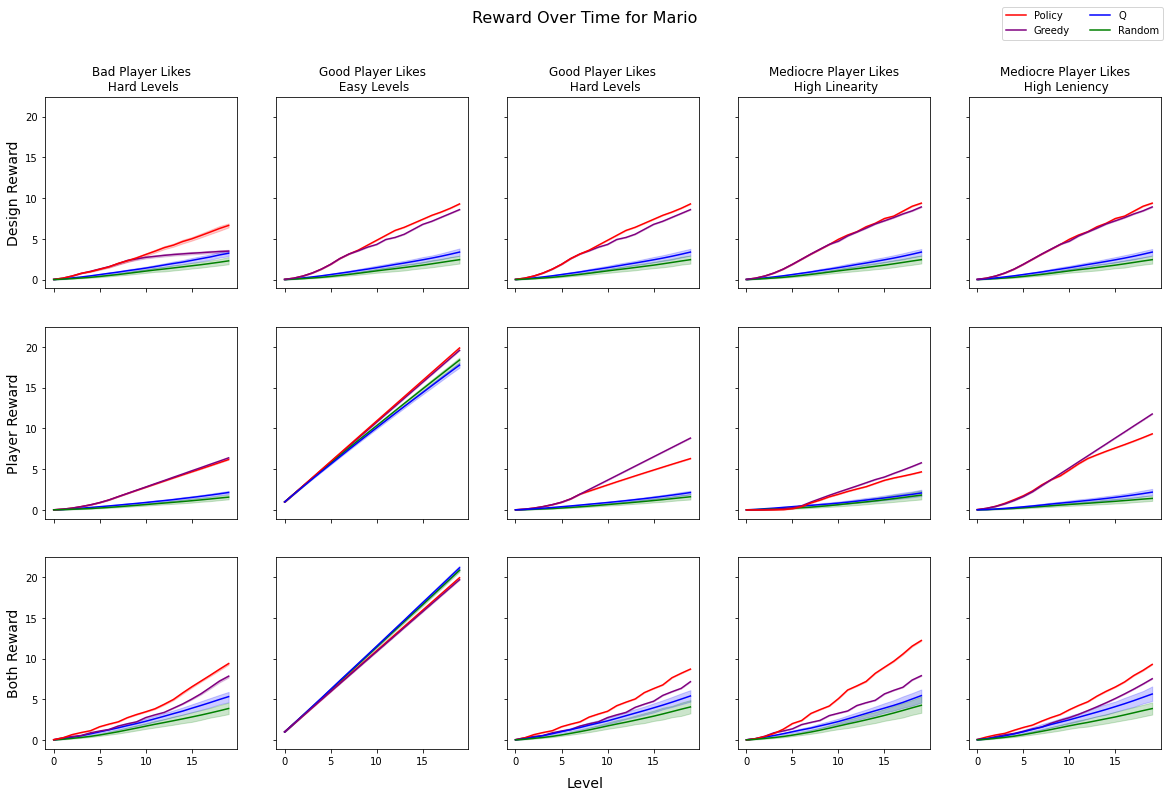

In [9]:
plot_player_personas_over_time(info)

In [10]:
def heatmap(data_info, graph, bounds, player_name):
    # heat map is only built for both reward
    max_x, max_y = bounds
    max_val = 0
    heatmap_data = {}
    
    name, playthrough, _ = data_info[2] 
    max_x, max_y = bounds
    
    # build heatmaps
    for session in playthrough:
        p_name = session[0]
        if p_name != player_name:
            continue
            
        data = np.zeros((max_x+1, max_y+1))
        mask = np.ones((max_x+1, max_y+1))
        
        # build the mask
        for n in graph.nodes:
            if '__' in n:
                continue

            a,b,_ = n.split(',')
            mask[int(a)][int(b)] = 0.0
            
        # heatmap counts
        for run in session[2]:
            for lvl in run:
                for node in lvl['Playthrough']:
                    if '__' in node['node_name']:
                        continue

                    a, b, _ = node['node_name'].split(',')
                    data[int(a)][int(b)] += 1.0
        
        # the heat map needs to be averaged by the number of runs and
        # the number of elites per cell. Maximum 4 and minimum 1.
        num_runs = len(session[2])
        counter = {}
        for node in graph.nodes:
            if '__' in node:
                continue
                
            a,b,_ = node.split(',')
            key = (int(a), int(b))
            if key in counter:
                counter[key] += 1
            else:
                counter[key] = 1
                
        for (a,b), count in counter.items():
            data[a][b] /= num_runs*count
            max_val = max(data[a][b], max_val)
            
        heatmap_data[session[1]] = (data, mask)
        
    fig, axes = plt.subplots(1, 4, sharex=True, sharey=True, figsize=(20,4))
    cbar_ax = fig.add_axes([.92, .1, .02, .77])
    
    ordered_directors = list(heatmap_data.keys())
    ordered_directors.sort()
    
    for i, director in enumerate(ordered_directors):
        data, mask = heatmap_data[director]
        ax = sns.heatmap(
            data, 
            mask=mask,
            square=True,
            cmap='RdBu',
            ax=axes[i],
            cbar_ax=None if i != 3 else cbar_ax,
            cbar=i==3,
            vmin=0,
            vmax=max_val
        )
        
        axes[i].invert_yaxis()
#         axes[i].set_title(f'{director}', y=-0.1)
        axes[i].set_title(director)
        axes[i].set_facecolor("gray")
        axes[i].set_xticks([])
        axes[i].set_yticks([])
        axes[i].set_aspect('auto')
        
        if i == 0:
            axes[i].set_ylabel('Leniency', fontsize=14)
    
    fig.suptitle(f'Mediocre Player Likes High Linearity with Both Rewards', fontsize=16, y=0.99)
    fig.text(0.5, 0.02, 'Linearity', ha='center', size=14)
    plt.show()

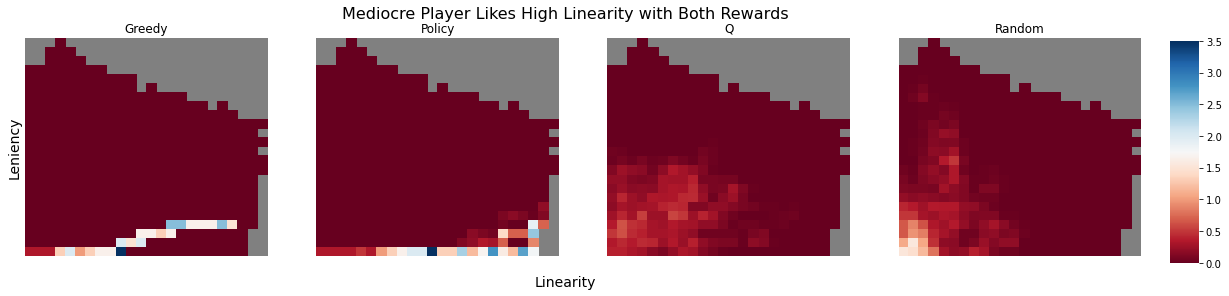

In [11]:
heatmap(info, graph, config.MAX_BC, 'Mediocre Player Likes High B')